<a href="https://colab.research.google.com/github/simon19891101/ML_experiments/blob/main/embedding_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [ ]:
# Load the MovieLens 1M dataset (only 'train' split is available)
ratings = tfds.load('movielens/100k-ratings', split='train')

# Convert the dataset to a Pandas DataFrame
ratings_df = tfds.as_dataframe(ratings)

# Preprocess the DataFrame: Convert bytes to strings and then to integers
ratings_df['movie_id'] = ratings_df['movie_id'].str.decode('utf-8').astype(np.int64)
ratings_df['user_id'] = ratings_df['user_id'].str.decode('utf-8').astype(np.int64)

# Create LabelEncoders and fit on the DataFrame
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

user_encoder.fit(ratings_df['user_id'])
movie_encoder.fit(ratings_df['movie_id'])

# Transform the IDs in the DataFrame
ratings_df['user_id_encoded'] = user_encoder.transform(ratings_df['user_id'])
ratings_df['movie_id_encoded'] = movie_encoder.transform(ratings_df['movie_id'])
ratings_df['label'] = ratings_df['user_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Get the number of unique users and movies
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)

In [ ]:
def gini(x):
    """Compute the Gini coefficient of a vector."""
    x = np.abs(x.flatten()) + 1e-12  # Avoid division by zero
    x_sorted = np.sort(x)
    n = len(x)
    cumulative = np.cumsum(x_sorted)
    gini_coeff = (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n
    return gini_coeff

def hoyer_sparsity(x):
    """Compute Hoyer's sparsity measure of a vector."""
    x = np.abs(x.flatten())
    n = len(x)
    l1 = np.sum(x)
    l2 = np.sqrt(np.sum(x ** 2))
    if l1 == 0:
        return 0.0
    return (np.sqrt(n) - (l1 / l2)) / (np.sqrt(n) - 1)

def vector_entropy(x):
    """Compute entropy of normalized absolute vector components."""
    x = np.abs(x.flatten()) + 1e-12
    p = x / np.sum(x)
    return -np.sum(p * np.log(p))

def spectral_entropy(E):
    """Compute spectral entropy from an embedding matrix E (rows = vectors)."""
    # Compute covariance matrix
    cov = np.cov(E, rowvar=False)
    # Compute eigenvalues
    eigvals = np.linalg.eigvalsh(cov)
    eigvals = np.clip(eigvals, a_min=1e-12, a_max=None)  # avoid log(0)
    p = eigvals / np.sum(eigvals)
    return -np.sum(p * np.log(p))

### Experiment

In [ ]:
# Prepare the training and test data
X_train = [train_df['user_id_encoded'].values, train_df['movie_id_encoded'].values]
y_train = train_df['label'].values  # Assuming the second column is the rating

X_test = [test_df['user_id_encoded'].values, test_df['movie_id_encoded'].values]
y_test = test_df['label'].values  # Assuming the second column is the rating

In [ ]:
def build_model(emb_dim=16, optimizer='adam'):
  tf.keras.backend.clear_session()

  # Define the embedding dimensions
  user_embedding_dim = emb_dim
  movie_embedding_dim = emb_dim

  # Create the user embedding layer
  user_embedding_layer = tf.keras.layers.Embedding(
      input_dim=num_users,
      output_dim=user_embedding_dim,
      name='user_embedding_layer'
  )

  # Create the movie embedding layer
  movie_embedding_layer = tf.keras.layers.Embedding(
      input_dim=num_movies,
      output_dim=movie_embedding_dim,
      name='movie_embedding_layer'
  )

  # Define the model
  input_user_id = tf.keras.Input(shape=(1,), dtype=tf.int64)
  input_movie_id = tf.keras.Input(shape=(1,), dtype=tf.int64)

  user_embedding = user_embedding_layer(input_user_id)
  movie_embedding = movie_embedding_layer(input_movie_id)

  # Concatenate the embeddings
  concatenated_embeddings = tf.keras.layers.Concatenate()([user_embedding, movie_embedding])

  # Add a dense layer for prediction
  output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated_embeddings)
  output = tf.keras.layers.Reshape((1,))(output)

  # Create the model
  model = tf.keras.Model(inputs=[input_user_id, input_movie_id], outputs=output)

  # Compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
#eval_results = []
emb_dim = 8
num_epochs = 20

#for optimizer in ['adam', 'sgd']:
for optimizer in ['sgd']:
  for batch_size in [1, 8, 16, 32]:
    model = build_model(emb_dim=emb_dim, optimizer=optimizer)
    for epoch in range(num_epochs):
        print(optimizer, batch_size, epoch)
        history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0)
        user_embeddings = model.get_layer('user_embedding_layer').get_weights()[0]
        movie_embeddings = model.get_layer('movie_embedding_layer').get_weights()[0]

        embeddings = np.concatenate([user_embeddings, movie_embeddings])

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        gini_score = round(float(np.mean(list(map(gini, embeddings)))),4)
        hoyer_sparsity_score = round(float(np.mean(list(map(hoyer_sparsity, embeddings)))),4)
        vector_entropy_score = round(float(np.mean(list(map(vector_entropy, embeddings)))),4)
        spectral_entropy_score = round(float(spectral_entropy(embeddings)),4)

        eval_results.append({'optimizer': optimizer,
                             'batch_size': batch_size,
                             'epoch': epoch+1,
                            'emb_dim': emb_dim,
                            'train_loss': round(history.history['loss'][0], 4),
                            'train_accuracy': round(history.history['accuracy'][0],4),
                            'test_loss': round(test_loss, 4),
                            'test_accuracy': round(test_accuracy,4),
                            'gini_score': gini_score,
                            'hoyer_sparsity_score': hoyer_sparsity_score,
                            'vector_entropy_score': vector_entropy_score,
                            'spectral_entropy_score': spectral_entropy_score}
                            )



sgd 1 0
sgd 1 1
sgd 1 2
sgd 1 3
sgd 1 4
sgd 1 5
sgd 1 6
sgd 1 7
sgd 1 8
sgd 1 9
sgd 1 10
sgd 1 11
sgd 1 12
sgd 1 13
sgd 1 14
sgd 1 15
sgd 1 16
sgd 1 17
sgd 1 18
sgd 1 19
sgd 8 0
sgd 8 1
sgd 8 2
sgd 8 3
sgd 8 4
sgd 8 5
sgd 8 6
sgd 8 7
sgd 8 8
sgd 8 9
sgd 8 10
sgd 8 11
sgd 8 12
sgd 8 13
sgd 8 14
sgd 8 15
sgd 8 16
sgd 8 17
sgd 8 18
sgd 8 19
sgd 16 0
sgd 16 1
sgd 16 2
sgd 16 3
sgd 16 4
sgd 16 5
sgd 16 6
sgd 16 7
sgd 16 8
sgd 16 9
sgd 16 10
sgd 16 11
sgd 16 12
sgd 16 13
sgd 16 14
sgd 16 15
sgd 16 16
sgd 16 17
sgd 16 18
sgd 16 19
sgd 32 0
sgd 32 1
sgd 32 2
sgd 32 3
sgd 32 4
sgd 32 5
sgd 32 6
sgd 32 7
sgd 32 8
sgd 32 9
sgd 32 10
sgd 32 11
sgd 32 12
sgd 32 13
sgd 32 14
sgd 32 15
sgd 32 16
sgd 32 17
sgd 32 18
sgd 32 19


In [ ]:
drive_path = os.path.join(os.getcwd(), *['drive', 'My Drive'])

eval_results = pd.DataFrame(eval_results)
eval_results.to_csv(drive_path+'/eval_results.csv', index=False)

In [ ]:
drive_path = os.path.join(os.getcwd(), *['drive', 'My Drive'])

eval_results = pd.read_csv(drive_path+'/eval_results.csv')

In [ ]:
eval_results.groupby('optimizer')[['batch_size','epoch']].nunique()

,batch_size,epoch
optimizer,,
adam,4,20
sgd,4,20


## SGD

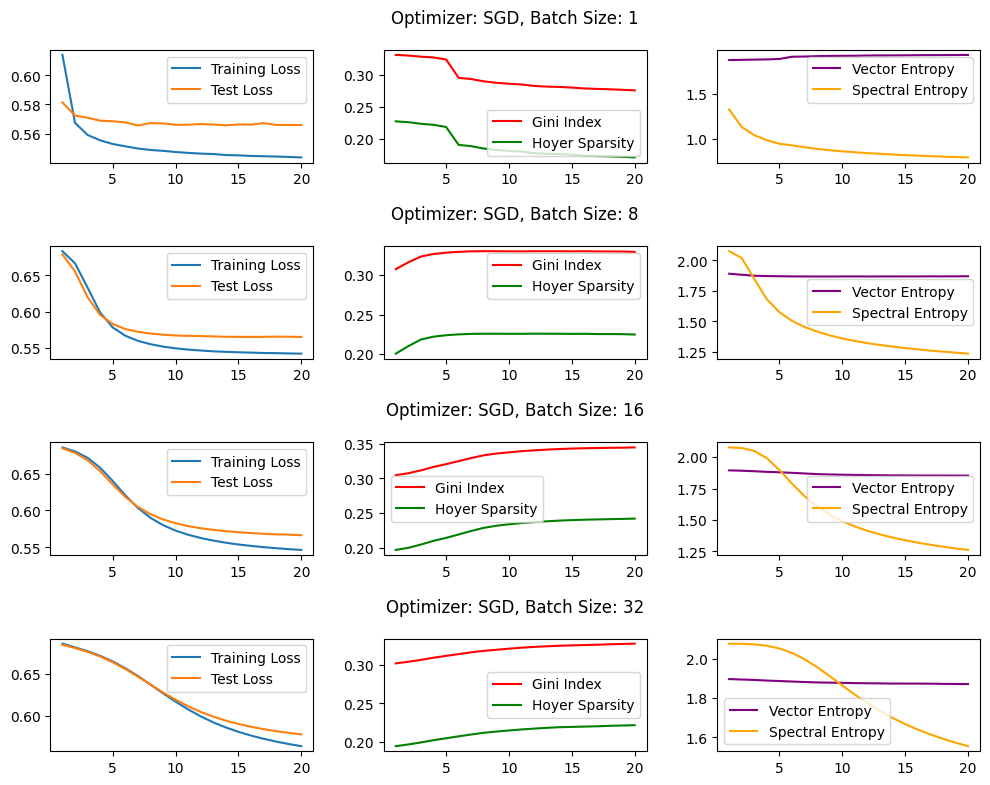

In [ ]:
# Define the grid layout
optimizers = eval_results['optimizer'].unique()
batch_sizes = eval_results['batch_size'].unique()

num_rows = len(batch_sizes)  # Number of rows in the grid
num_cols = 3   # Number of columns in the grid

# Create subplots with specified layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop through optimizers and batch sizes
plot_index = 0  # Keep track of the current subplot index
optimizer = 'sgd'
for i, batch_size in enumerate(batch_sizes):
    eval_result = eval_results.query('optimizer == @optimizer').query('batch_size == @batch_size').query('epoch <= 20')

    # Add row title on top of each row using a text annotation
    title = f'Optimizer: SGD, Batch Size: {batch_size}'
    axs[i * num_cols + 1].text(0.5, 1.2, title, ha='center', va='bottom', transform=axs[i * num_cols+1].transAxes, fontsize=12)


    # Plot loss on the current subplot
    axs[plot_index].plot(eval_result['epoch'], eval_result['train_loss'], label='Training Loss')
    axs[plot_index].plot(eval_result['epoch'], eval_result['test_loss'], label='Test Loss')
    #axs[plot_index].set_title('Loss')
    axs[plot_index].legend()

    # Move to the next subplot for Gini score
    plot_index += 1

    # Plot Gini score on the next subplot
    axs[plot_index].plot(eval_result['epoch'], eval_result['gini_score'], label='Gini Index', color='red')
    axs[plot_index].plot(eval_result['epoch'], eval_result['hoyer_sparsity_score'], label='Hoyer Sparsity', color='green')

    #axs[plot_index].set_title('Gini/Hoyer')
    axs[plot_index].legend()

    plot_index += 1  # Move to the next subplot

    axs[plot_index].plot(eval_result['epoch'], eval_result['vector_entropy_score'], label='Vector Entropy', color='purple')
    axs[plot_index].plot(eval_result['epoch'], eval_result['spectral_entropy_score'], label='Spectral Entropy', color='orange')

    #axs[plot_index].set_title(f'Entropy')
    axs[plot_index].legend()

    plot_index += 1  # Move to the next subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Adam

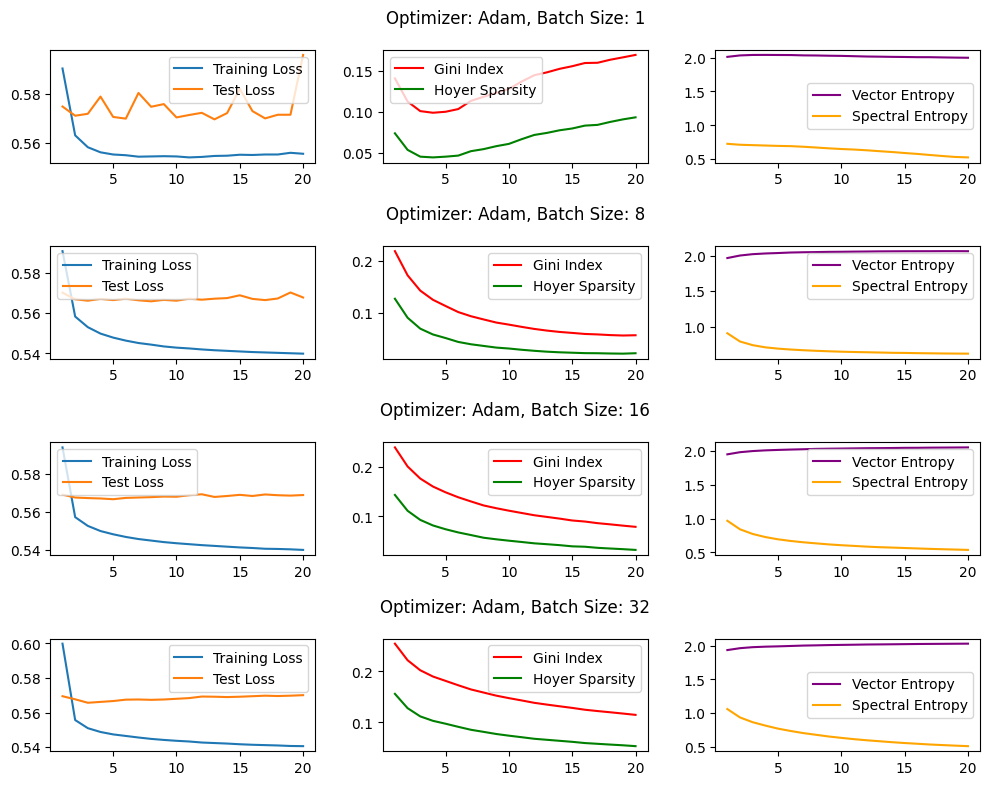

In [ ]:
# Define the grid layout
optimizers = eval_results['optimizer'].unique()
batch_sizes = eval_results['batch_size'].unique()

num_rows = len(batch_sizes)  # Number of rows in the grid
num_cols = 3   # Number of columns in the grid

# Create subplots with specified layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop through optimizers and batch sizes
plot_index = 0  # Keep track of the current subplot index
optimizer = 'adam'
for i, batch_size in enumerate(batch_sizes):
    eval_result = eval_results.query('optimizer == @optimizer').query('batch_size == @batch_size').query('epoch <= 20')

    # Add row title on top of each row using a text annotation
    title = f'Optimizer: Adam, Batch Size: {batch_size}'
    axs[i * num_cols + 1].text(0.5, 1.2, title, ha='center', va='bottom', transform=axs[i * num_cols+1].transAxes, fontsize=12)


    # Plot loss on the current subplot
    axs[plot_index].plot(eval_result['epoch'], eval_result['train_loss'], label='Training Loss')
    axs[plot_index].plot(eval_result['epoch'], eval_result['test_loss'], label='Test Loss')
    #axs[plot_index].set_title('Loss')
    axs[plot_index].legend()

    # Move to the next subplot for Gini score
    plot_index += 1

    # Plot Gini score on the next subplot
    axs[plot_index].plot(eval_result['epoch'], eval_result['gini_score'], label='Gini Index', color='red')
    axs[plot_index].plot(eval_result['epoch'], eval_result['hoyer_sparsity_score'], label='Hoyer Sparsity', color='green')

    #axs[plot_index].set_title('Gini/Hoyer')
    axs[plot_index].legend()

    plot_index += 1  # Move to the next subplot

    axs[plot_index].plot(eval_result['epoch'], eval_result['vector_entropy_score'], label='Vector Entropy', color='purple')
    axs[plot_index].plot(eval_result['epoch'], eval_result['spectral_entropy_score'], label='Spectral Entropy', color='orange')

    #axs[plot_index].set_title(f'Entropy')
    axs[plot_index].legend()

    plot_index += 1  # Move to the next subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()